# Imports

In [3]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

# Naive 1D Convolution

In [4]:
def conv_1d(x : list, w : list, p : int = 0, s : int = 1) -> np.array :
    
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    
    if p > 0 :
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate([zero_pad, x_padded, zero_pad])
        
    res = []
    for i in range(0, int((len(x_padded) - len(w_rot))) + 1, s):
        res.append(np.sum(x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)

x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

conv_1d(x, w, 2, 1) # Naive Implementation
np.convolve(x, w, mode='same') # Numpy Version

array([ 5, 14, 16, 26, 24, 34, 19, 22])

In [5]:
import scipy.signal

def conv_2d(x, w, p=(0,0), s=(1,1)):
    
    w_rot = np.array(w)[::-1, ::-1]
    x_orig = np.array(x)
    
    n1 = x_orig.shape[0] + 2*p[0]
    n2 = x_orig.shape[1] + 2*p[1]
    
    x_padded = np.zeros(shape=(n1, n2))
    x_padded[p[0]:p[0]+x_orig.shape[0], p[1]:p[1]+x_orig.shape[1]] = x_orig
    
    res = []
    
    for i in range(0, int((x_padded.shape[0] - w_rot.shape[0]) / s[0]) + 1, s[0]):
        res.append([])
        for j in range(0, int((x_padded.shape[1] - w_rot.shape[1]) / s[1]) + 1,  s[1]):
            x_sub = x_padded[i:i+w_rot.shape[0],j:j+w_rot.shape[1]]
            res[-1].append(np.sum(x_sub * w_rot))
            
    return np.array(res)

x = [
    [1, 3, 2, 4],
    [5, 6, 1, 3],
    [1, 2, 0, 2],
    [3, 4, 3, 2]
]

w = [
    [1, 0, 3],
    [1, 2, 1],
    [0, 1, 1]
]
conv_2d(x, w, (1,1), (1,1))
scipy.signal.convolve2d(x, w, 'same')

array([[11, 25, 32, 13],
       [19, 25, 24, 13],
       [13, 28, 25, 17],
       [11, 17, 14,  9]])

# Implementing a deep CNN in PyTorch

## Loading and preprocessing the MNIST data

In [6]:
import torchvision
from torchvision import transforms
from torch.utils.data import Subset, DataLoader

img_path = './'

transform = transforms.Compose([transforms.ToTensor()])

mnist_data = torchvision.datasets.MNIST(root=img_path, train=True, transform=transform, download=True)

''' Use first 10k for validation '''
mnist_valid = Subset(mnist_data, torch.arange(10_000))
mnist_train = Subset(mnist_data, torch.arange(10_000, len(mnist_data)))
mnist_test = torchvision.datasets.MNIST(root=img_path, train=False, transform=transform, download=False)

batch_size = 64
torch.manual_seed(1)

train_dl = DataLoader(mnist_train, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid, batch_size, shuffle=False)

## Constructing the CNN in PyTorch

In [9]:
model = nn.Sequential()

model.add_module(
    'conv1',
    nn.Conv2d(1, 32, 5, padding=2)
)

model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(2))

model.add_module(
    'conv2',
    nn.Conv2d(32, 64, 5, padding=2)
)

model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(2))

model.add_module('flatten', nn.Flatten())

x = torch.ones([4, 1, 28, 28])

# model(x).shape

model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=.5))
model.add_module('fc2', nn.Linear(1024, 10))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

In [11]:
def train(model : nn.Sequential, num_epochs : int, train_dl : DataLoader, valid_dl : DataLoader):
    
    loss_hist_train = [0] * num_epochs
    accu_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accu_hist_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):
        
        model.train()
        
        for x_batch, y_batch in train_dl:
            
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            
            is_correct = (
                torch.argmax(pred, dim=1) == y_batch
            ).float()
            
            accu_hist_train[epoch] += is_correct.sum()
            
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accu_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accu_hist_valid[epoch] += is_correct.sum()
        
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accu_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch + 1}:\n\tTrain Accuracy: {accu_hist_train[epoch]:.4f}\n\tValid Accuracy: {accu_hist_valid[epoch]:.4f}')
        
    return loss_hist_train, loss_hist_valid, accu_hist_train, accu_hist_valid

torch.manual_seed(1)
num_epochs = 20

hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1:
	Train Accuracy: 0.9493
	Valid Accuracy: 0.9797
Epoch 2:
	Train Accuracy: 0.9840
	Valid Accuracy: 0.9843
Epoch 3:
	Train Accuracy: 0.9891
	Valid Accuracy: 0.9902
Epoch 4:
	Train Accuracy: 0.9912
	Valid Accuracy: 0.9879
Epoch 5:
	Train Accuracy: 0.9933
	Valid Accuracy: 0.9906
Epoch 6:
	Train Accuracy: 0.9939
	Valid Accuracy: 0.9893
Epoch 7:
	Train Accuracy: 0.9949
	Valid Accuracy: 0.9899
Epoch 8:
	Train Accuracy: 0.9959
	Valid Accuracy: 0.9869
Epoch 9:
	Train Accuracy: 0.9968
	Valid Accuracy: 0.9895
Epoch 10:
	Train Accuracy: 0.9965
	Valid Accuracy: 0.9889
Epoch 11:
	Train Accuracy: 0.9973
	Valid Accuracy: 0.9899
Epoch 12:
	Train Accuracy: 0.9974
	Valid Accuracy: 0.9897
Epoch 13:
	Train Accuracy: 0.9981
	Valid Accuracy: 0.9926
Epoch 14:
	Train Accuracy: 0.9975
	Valid Accuracy: 0.9901
Epoch 15:
	Train Accuracy: 0.9977
	Valid Accuracy: 0.9921
Epoch 16:
	Train Accuracy: 0.9978
	Valid Accuracy: 0.9911
Epoch 17:
	Train Accuracy: 0.9981
	Valid Accuracy: 0.9904
Epoch 18:
	Train Accura

# Visualizng The Learning Curves

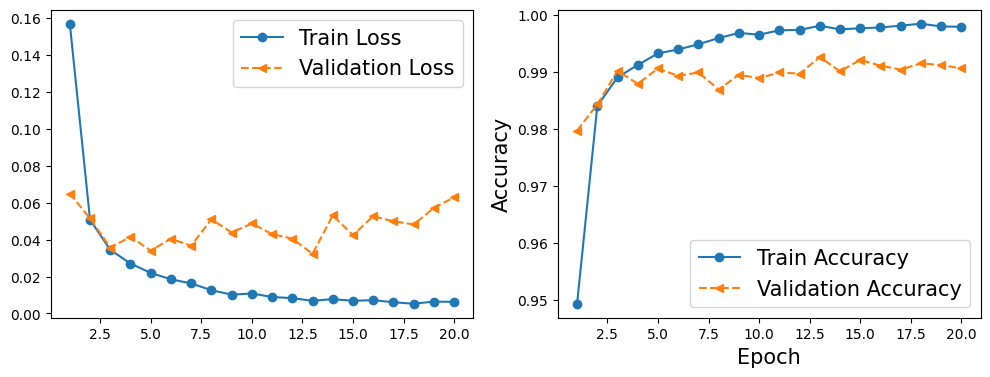

In [15]:
import matplotlib.pyplot as plt

x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train Loss')
ax.plot(x_arr, hist[1], '--<', label='Validation Loss')
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train Accuracy')
ax.plot(x_arr, hist[3], '--<', label='Validation Accuracy')
ax.legend(fontsize=15)
ax.set_xlabel("Epoch", size=15)
ax.set_ylabel("Accuracy", size=15)
plt.show()

#  Evaluating our trained model on the test dataset

In [17]:
pred = model(mnist_test.data.unsqueeze(1) / 255.)
is_correct = (
    torch.argmax(pred, dim=1) == mnist_test.targets
).float()
print(f'Test Accuracy: {is_correct.mean():.4f}')

Test Accuracy: 0.9931


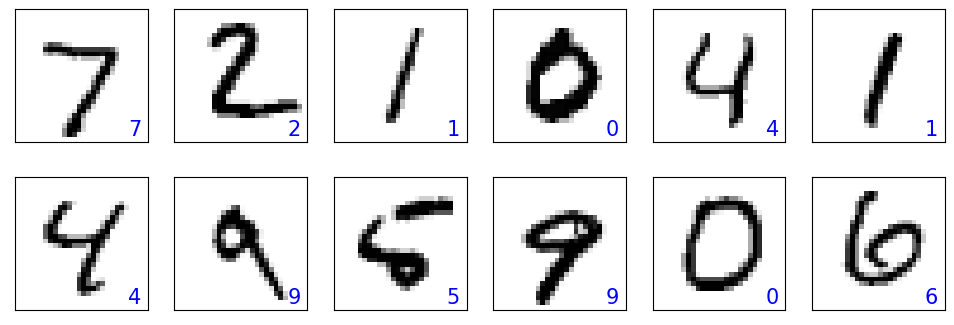

In [21]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    img = mnist_test[i][0][0,:,:]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(.9, .1, y_pred.item(), size=15, color='blue', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.show()